In [2]:
from PIL import Image
import pickle
from sklearn.model_selection import train_test_split
import numpy as np
import imageio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms

In [4]:
# Had problems with overloading memory so tried to clear the cache often

torch.cuda.empty_cache()

# Information about transforming images for training, where the images are located and how to load for 
# sending to the neural net

data_transforms = {
    'train':
        transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()]),
    'validation':
        transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])}
 
image_datasets = {
    'train':
        datasets.ImageFolder('images/train', data_transforms['train']),
    'validation':
        datasets.ImageFolder('images/validate', data_transforms['validation'])}
 
dataloaders = {
    'train':
        torch.utils.data.DataLoader(
            image_datasets['train'],
            batch_size=64,
            shuffle=True,
            num_workers=4),
    'validation':
        torch.utils.data.DataLoader(
            image_datasets['validation'],
            batch_size=64,
            shuffle=False,
            num_workers=4)}

In [12]:
# Use GPUs on AWS. 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Preload the resnet50 model and add the final layers for my own data

model = models.resnet50(pretrained=True).to(device)
 
for param in model.parameters():
    param.requires_grad = False
 
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters())

In [7]:
# train the model!

def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
 
        torch.cuda.empty_cache()

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
 
            running_loss = 0.0
            running_corrects = 0
 
            torch.cuda.empty_cache()
    
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
 
                torch.cuda.empty_cache()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
 
                torch.cuda.empty_cache()

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    torch.cuda.empty_cache()
 
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
 
                torch.cuda.empty_cache()

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
 
            torch.cuda.empty_cache()

            print(f'{phase} loss: {epoch_loss}, acc: {epoch_acc}')
    return model
 

In [14]:
model_trained = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
train loss: 0.4305762911574617, acc: 0.7934995289513733
validation loss: 0.3435701319445734, acc: 0.855
Epoch 2/10
----------
train loss: 0.4230444052032098, acc: 0.7983187187477354
validation loss: 0.3374118270563043, acc: 0.8543478260869566
Epoch 3/10
----------
train loss: 0.4119449613431077, acc: 0.8028842669758679
validation loss: 0.329377966341765, acc: 0.8602173913043478
Epoch 4/10
----------
train loss: 0.413035917633279, acc: 0.8038263642292921
validation loss: 0.3320389008522034, acc: 0.858804347826087
Epoch 5/10
----------
train loss: 0.4126551700002068, acc: 0.8024494528589029
validation loss: 0.34159432281618535, acc: 0.8555434782608696
Epoch 6/10
----------
train loss: 0.40115325542815966, acc: 0.8099862308862962
validation loss: 0.3323076491252236, acc: 0.8607608695652175
Epoch 7/10
----------
train loss: 0.3954040284121898, acc: 0.8126675846075804
validation loss: 0.3221077836078146, acc: 0.8591304347826088
Epoch 8/10
----------
train loss: 0.39120

In [30]:
validation_img_paths = ["images/test/1/39327.jpg",
                        "images/test/1/35404.jpg",
                        "images/test/0/40684.jpg",
                        "images/test/0/35402.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]


In [31]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])
 
pred_logits_tensor = model(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

[[0.22774594 0.77225405]
 [0.2749141  0.725086  ]
 [0.5852924  0.4147076 ]
 [0.83414704 0.16585293]]


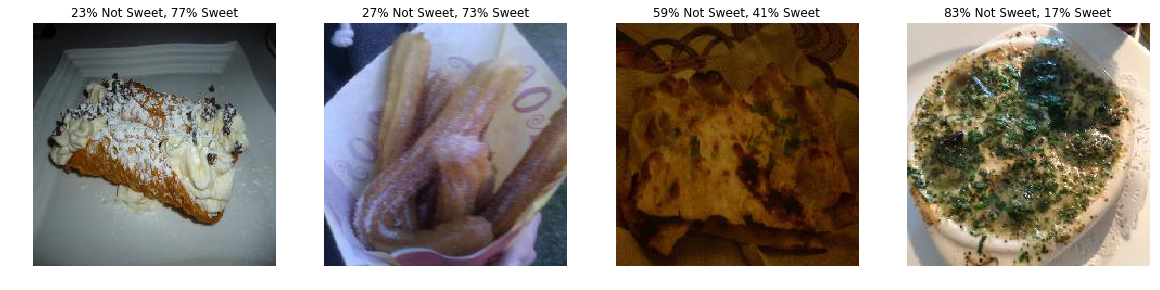

In [32]:

fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Not Sweet, {:.0f}% Sweet".format(100*pred_probs[i,0],
                                                          100*pred_probs[i,1]))
    ax.imshow(img)
print(pred_probs)

# Looks good

In [37]:
pred_y = model(validation_batch)
F.max(pred_y, dim=1).cpu().data.numpy()

AttributeError: module 'torch.nn.functional' has no attribute 'max'

In [34]:
# Output model

torch.save(model_trained.state_dict(),'models/cva_weights_first_model.h5')

In [5]:

# Import model to run for a few more epochs to see if there is more improvement.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('models/cva_weights.h5'))

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters())

In [10]:
model_trained = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
train loss: 0.37630030399855086, acc: 0.8219798536125807
validation loss: 0.31003503524738807, acc: 0.866195652173913
Epoch 2/10
----------
train loss: 0.37687144057285404, acc: 0.8233929994927169
validation loss: 0.3204185895297838, acc: 0.8630434782608696
Epoch 3/10
----------
train loss: 0.37304560761839095, acc: 0.825168490470324
validation loss: 0.33355643458988354, acc: 0.8556521739130435
Epoch 4/10
----------
train loss: 0.37401471513191403, acc: 0.8245887383143706
validation loss: 0.31813244581222533, acc: 0.8634782608695653
Epoch 5/10
----------
train loss: 0.3632921941086506, acc: 0.8281034857598377
validation loss: 0.31374698602634926, acc: 0.8607608695652175
Epoch 6/10
----------
train loss: 0.3654117452808027, acc: 0.8275962026233786
validation loss: 0.3239177658246911, acc: 0.8583695652173914
Epoch 7/10
----------
train loss: 0.3591944342899585, acc: 0.8346981665338069
validation loss: 0.32375138210213705, acc: 0.858804347826087
Epoch 8/10
----------

In [11]:
# There is more improvement, but cross validation is holding steady so keep this model as is as use

torch.save(model_trained.state_dict(),'models/cva_weights_second_model.h5')